In [1]:
from segysak.segy import segy_freeloader, segy_header_scrape
from matplotlib.patches import Rectangle
from segysak.segy import segy_loader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import segyio
import os

/home/gaia/.local/lib/python3.8/site-packages/segysak/segy/_segy_core.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
default_file = r'/home/gaia/jpedro/Seismic_data_w_null.sgy'
similarity_file = r'/home/gaia/jpedro/F3_Similaridade_Full (455).sgy'

#default_file = r'/mnt/hgfs/shared_folder/Seismic_data_w_null.sgy'
#similarity_file = r'/mnt/hgfs/shared_folder/F3_Similaridade_Full (455).sgy'

default_block = segyio.open(default_file)

In [4]:
#segy_header_scrape(similarity_file)

In [3]:
similarity_block = segy_loader(similarity_file, iline=189, xline=193, cdpx=181, cdpy=185)

  0%|          | 0.00/601k [00:00<?, ? traces/s]

Loading as 3D
Fast direction is INLINE_3D


Converting SEGY:   0%|          | 0.00/601k [00:00<?, ? traces/s]

In [5]:
similarity_block

<xarray.Dataset>
Dimensions:  (iline: 651, xline: 951, twt: 455)
Coordinates:
  * iline    (iline) uint16 100 101 102 103 104 105 ... 745 746 747 748 749 750
  * xline    (xline) uint16 300 301 302 303 304 305 ... 1246 1247 1248 1249 1250
  * twt      (twt) float64 8.0 12.0 16.0 20.0 ... 1.816e+03 1.82e+03 1.824e+03
    cdp_x    (iline, xline) float32 6.058e+05 6.059e+05 ... 6.291e+05 6.291e+05
    cdp_y    (iline, xline) float32 6.074e+06 6.074e+06 ... 6.09e+06 6.09e+06
Data variables:
    data     (iline, xline, twt) float32 1.0 1.0 1.0 ... 0.1306 0.1263 0.1607
Attributes: (12/13)
    ns:                  None
    sample_rate:         4.0
    text:                C01  Created by: OpendTect     (seg 27 jan 2020, 07:...
    measurement_system:  m
    d3_domain:           None
    epsg:                None
    ...                  ...
    corner_points_xy:    None
    source_file:         F3_Similaridade_Full (455).sgy
    srd:                 None
    datatype:            None
    percentiles:         [0.009095821378983727, 0.010286564565431689, 0.08139...
    coord_scalar:        -10.0

In [6]:
similarity_block.iline.to_numpy()

array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
       113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
       139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151,
       152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
       165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177,
       178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190,
       191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203,
       204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
       217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229,
       230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242,
       243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255,
       256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268,
       269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 28

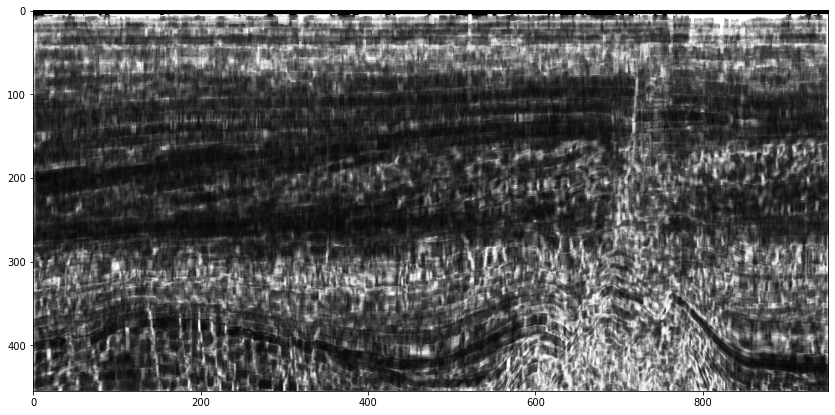

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(15,7))

img = similarity_block.isel(iline=100).data.T.to_numpy()

ax.imshow(img, cmap='gray_r')

CLASSIFICATION

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import segyio

In [9]:
def obj_to_pixel_df(cube, obj, width, height, index_label, derivative='default'):

    dataset = pd.DataFrame()

    if width % 2 > 0:
        width_coef = 1
    else:
        width_coef = 0
    
    if height % 2 > 0:
        height_coef = 1
    else:
        height_coef = 0

    half_width = int(round(width / 2 - 0.5, 0))
    half_height = int(round(height / 2 - 0.5, 0))
    
    count = 0
    for click in obj:
        iline_number = click['inline']
        xline_number = click['crossline']

        x = click['x']
        y = click['y']

        if iline_number != None:
            img = cube.isel(iline=iline_number).data.T.to_numpy()[x - half_width : x + half_width + width_coef, y - half_height : y + half_height + height_coef]
        else:
            img = cube.isel(xline=xline_number).data.T.to_numpy()[x - half_width : x + half_width + width_coef, y - half_height : y + half_height + height_coef]

        if derivative == 'horizontal':
            img = np.diff(img) / 25
        elif derivative == 'vertical':
            img = np.diff(img.T).T / 0.004

        pixels = img.reshape(-1,1)

        if derivative == 'default':
            if len(pixels) == int(width * height):
                dataset[count] = [pixel[0] for pixel in pixels.tolist()]
        else:
            if len(pixels) == int(width * height - width):
                dataset[count] = [pixel[0] for pixel in pixels.tolist()]

        count += 1

    dataset = dataset.T
    dataset.index = [f'{index_label}{i}' for i in range(len(dataset))]

    if index_label == 'Fault':
        dataset['y'] = [1 for i in range(len(dataset))]

    elif index_label == 'Non_Fault':
        dataset['y'] = [0 for i in range(len(dataset))]

    return dataset

In [10]:
file = open('Fault.obj', 'rb')
fault_obj = pickle.load(file)
file.close()

file = open('Non_Fault.obj', 'rb')
non_fault_obj = pickle.load(file)
file.close()

In [40]:
width = 11
height = 11

X_fault = obj_to_pixel_df(similarity_block, fault_obj, width, height, 'Fault')
X_non_fault = obj_to_pixel_df(similarity_block, non_fault_obj, width, height, 'Non_Fault')

dataset = pd.concat([X_fault, X_non_fault])

dataset.rename(columns={i : f'Pixel{i}' for i in range(len(dataset.columns) - 1)}, inplace=True)

dataset = dataset.sample(frac=1)

X = dataset.iloc[:,:-1]
y = dataset['y']

/tmp/ipykernel_3813/2262440437.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[count] = [pixel[0] for pixel in pixels.tolist()]


In [41]:
X

,Pixel0,Pixel1,Pixel2,Pixel3,Pixel4,Pixel5,Pixel6,Pixel7,Pixel8,Pixel9,...,Pixel111,Pixel112,Pixel113,Pixel114,Pixel115,Pixel116,Pixel117,Pixel118,Pixel119,Pixel120
Non_Fault130,0.876890,0.814855,0.778760,0.780149,0.812424,0.858342,0.856302,0.824912,0.831940,0.796156,...,0.660901,0.740790,0.857367,0.869765,0.835151,0.843150,0.813384,0.864940,0.870407,0.876537
Non_Fault406,0.526755,0.393478,0.395384,0.406153,0.358523,0.403440,0.330626,0.331571,0.280352,0.347885,...,0.600748,0.589306,0.512851,0.340863,0.337527,0.256419,0.619694,0.577924,0.643905,0.650326
Non_Fault208,0.559969,0.786574,0.877844,0.843192,0.700423,0.627649,0.656766,0.726700,0.738654,0.648436,...,0.758263,0.722689,0.720161,0.738066,0.693818,0.625932,0.630793,0.746558,0.790882,0.771838
Non_Fault62,0.925725,0.932376,0.951233,0.936105,0.908487,0.878937,0.875982,0.868064,0.885598,0.887584,...,0.808078,0.797565,0.752332,0.756823,0.865714,0.902055,0.910105,0.886620,0.879587,0.841897
Fault437,0.692758,0.515410,0.441331,0.445981,0.544567,0.579710,0.381915,0.378265,0.378064,0.303545,...,0.597125,0.687031,0.684615,0.673198,0.669032,0.607618,0.446340,0.236177,0.195954,0.233921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Non_Fault182,0.881030,0.847741,0.838980,0.879430,0.798353,0.804366,0.746938,0.793527,0.839019,0.836252,...,0.924222,0.928546,0.925916,0.910252,0.890577,0.879509,0.886136,0.879183,0.873265,0.839290
Fault242,0.715522,0.751031,0.794263,0.757657,0.724414,0.604365,0.553844,0.557143,0.604021,0.641997,...,0.913978,0.852272,0.847307,0.860311,0.798096,0.728666,0.808849,0.808759,0.810125,0.807121
Non_Fault451,0.798721,0.782813,0.780971,0.819409,0.879889,0.871749,0.855273,0.885197,0.893736,0.854667,...,0.664038,0.627971,0.767604,0.878158,0.853876,0.811974,0.800894,0.758063,0.837186,0.865568
Fault295,0.747643,0.698194,0.770246,0.794399,0.746283,0.792141,0.827525,0.782073,0.807967,0.859606,...,0.852503,0.794451,0.763828,0.870280,0.911831,0.900559,0.904103,0.895414,0.870154,0.869639


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=9, train_size=0.7)

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

In [22]:
model = DecisionTreeClassifier(criterion='entropy', max_depth=9)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

y_pred_train = model.predict(X_train)
acc_train = accuracy_score(y_train, y_pred_train)

print(f'Model Accuracy (Train): {round(acc_train * 100, 2)}% | Model Accuracy (Test): {round(acc * 100, 2)}%')

Model Accuracy (Train): 79.19% | Model Accuracy (Test): 48.05%


/home/gaia/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


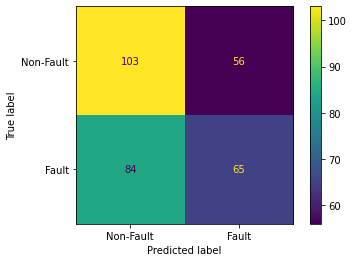

In [16]:
plot_confusion_matrix(model, X_test, y_test, display_labels=['Non-Fault', 'Fault'])

In [17]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.55      0.65      0.60       159
           1       0.54      0.44      0.48       149

    accuracy                           0.55       308
   macro avg       0.54      0.54      0.54       308
weighted avg       0.54      0.55      0.54       308



ValueError: cannot reshape array of size 420 into shape (21,21)

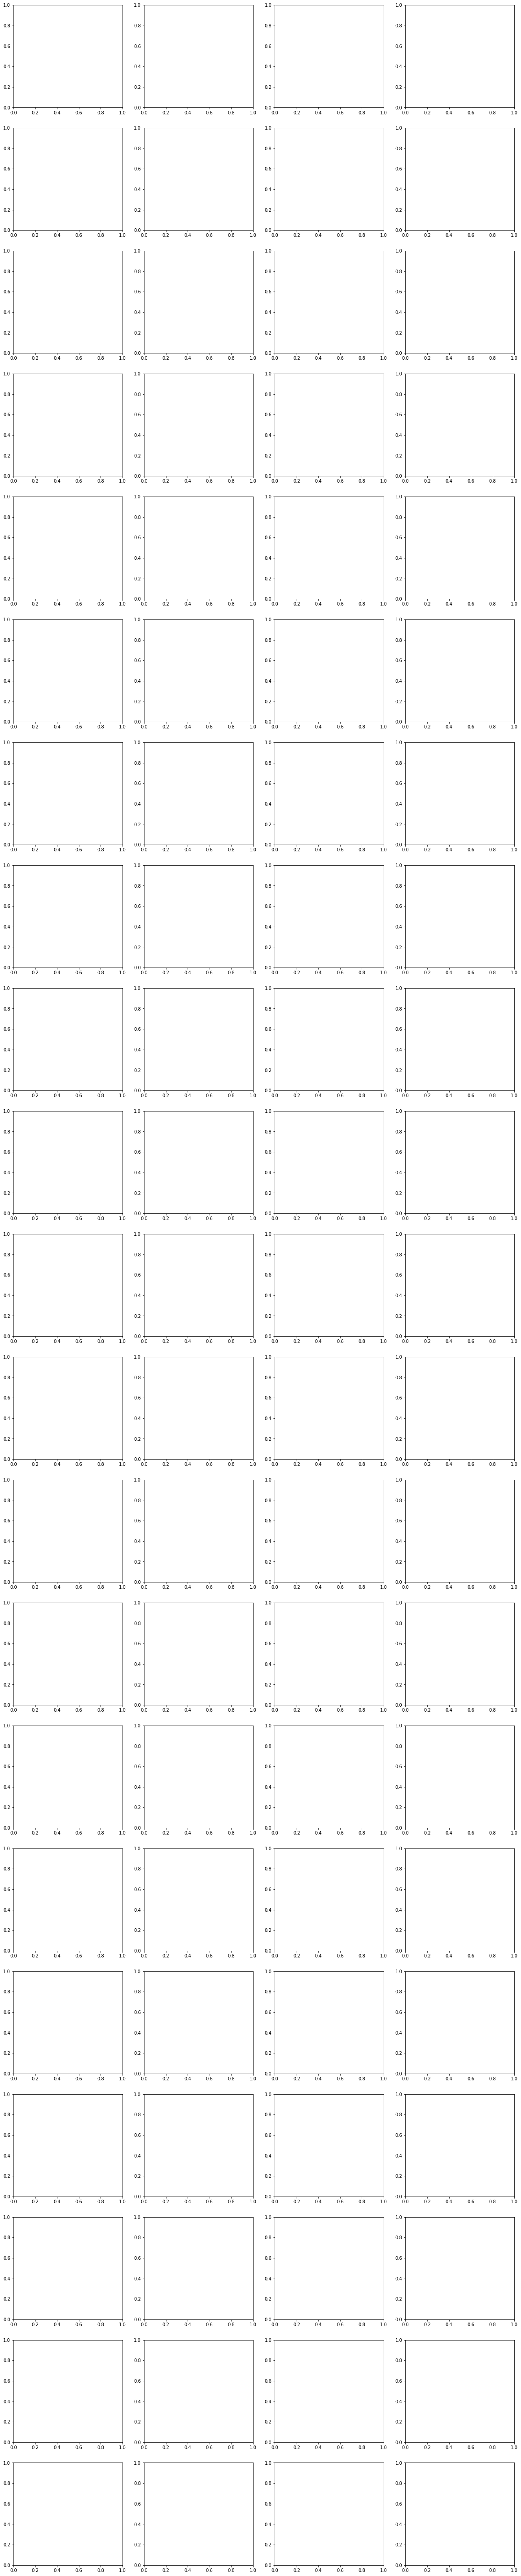

In [23]:
#FALHAS VERDADEIRO-POSITIVAS (CLASSIFICADA CORRETAMENTE COMO FALHA)

img_df = pd.DataFrame()
for i in range(len(y_test)):
    if y_pred[i] == 1 and y_test[i] == 1:
        img_df[X_test.copy().iloc[i].name] = X_test.copy().iloc[i]

cols = 4
rows = int(len(img_df.columns) / cols + 0.5)
fig, ax = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))

count = 0
for row in range(rows):
    for col in range(cols):

        img = np.array(img_df[img_df.columns[count]]).reshape(21,21)
        ax[row][col].imshow(img, cmap='Greys', interpolation='spline36')
        ax[row][col].set_title(img_df.columns[count])

        count += 1

In [20]:
derivatives = ['default', 'horizontal', 'vertical']
#derivatives = ['horizontal']

acc_train_list = []
acc_test_list = []
for derivative in derivatives:
    # CRIAÇÃO DOS DATASETS "X" E "y" E PARA TREINAMENTO E TESTE

    width = 21
    height = 21

    X_fault = obj_to_pixel_df(similarity_block, fault_obj, width, height, 'Fault', derivative)
    X_non_fault = obj_to_pixel_df(similarity_block, non_fault_obj, width, height, 'Non_Fault', derivative)

    dataset = pd.concat([X_fault, X_non_fault])

    dataset.rename(columns={i : f'Pixel{i}' for i in range(len(dataset.columns) - 1)}, inplace=True)

    dataset = dataset.sample(frac=1)

    X = dataset.iloc[:,:-1]
    y = dataset['y']

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=9, train_size=0.7)

    # TREINAMENTO E TESTE

    model = DecisionTreeClassifier(criterion='entropy', max_depth=9)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    y_pred_train = model.predict(X_train)
    acc_train = accuracy_score(y_train, y_pred_train)

    acc_train_list += [acc_train]
    acc_test_list += [acc]

for i in range(len(derivatives)):

    print(f'Derivative: {derivatives[i]} | Model Accuracy (Train): {round(acc_train_list[i] * 100, 2)}% | Model Accuracy (Test): {round(acc_test_list[i] * 100, 2)}%')

/tmp/ipykernel_3813/2262440437.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[count] = [pixel[0] for pixel in pixels.tolist()]
/tmp/ipykernel_3813/2262440437.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[count] = [pixel[0] for pixel in pixels.tolist()]
/tmp/ipykernel_3813/2262440437.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) inst

Derivative: default | Model Accuracy (Train): 86.03% | Model Accuracy (Test): 56.17%
Derivative: horizontal | Model Accuracy (Train): 77.23% | Model Accuracy (Test): 55.84%
Derivative: vertical | Model Accuracy (Train): 79.19% | Model Accuracy (Test): 45.45%


In [24]:
from sklearn.ensemble import RandomForestClassifier


In [32]:
rfc = RandomForestClassifier(n_estimators=70)
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=70)

In [33]:
y_pred = rfc.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(acc)

0.5487012987012987
